The following dataset, Google Play Store Apps, is from Kaggle. It was web scraped and was last updated February 3rd, 2019.

There are just over 10,000 entries, each of which is an application available on Google Play Store.

We predict the user rating of each application

In [1]:
import numpy as np
import pandas as pd
import scipy
import seaborn as sns
import sqlite3, datetime
from sklearn import linear_model
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV, ElasticNetCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
import pydotplus
import graphviz
import statsmodels.api as sm
from statsmodels.tools.eval_measures import mse, rmse
from scipy.stats.mstats import winsorize
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn import ensemble
from sklearn.model_selection import cross_val_score
from sklearn import tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from IPython.display import Image

# Display preferences.
%matplotlib inline
pd.options.display.float_format = '{:.3f}'.format
pd.set_option('display.max_columns', 100)

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('googleplaystore.csv')
df

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.100,159,19M,"10,000+",Free,0,Everyone,Art & Design,"January 7, 2018",1.0.0,4.0.3 and up
1,Coloring book moana,ART_AND_DESIGN,3.900,967,14M,"500,000+",Free,0,Everyone,Art & Design;Pretend Play,"January 15, 2018",2.0.0,4.0.3 and up
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.700,87510,8.7M,"5,000,000+",Free,0,Everyone,Art & Design,"August 1, 2018",1.2.4,4.0.3 and up
3,Sketch - Draw & Paint,ART_AND_DESIGN,4.500,215644,25M,"50,000,000+",Free,0,Teen,Art & Design,"June 8, 2018",Varies with device,4.2 and up
4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.300,967,2.8M,"100,000+",Free,0,Everyone,Art & Design;Creativity,"June 20, 2018",1.1,4.4 and up
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10836,Sya9a Maroc - FR,FAMILY,4.500,38,53M,"5,000+",Free,0,Everyone,Education,"July 25, 2017",1.48,4.1 and up
10837,Fr. Mike Schmitz Audio Teachings,FAMILY,5.000,4,3.6M,100+,Free,0,Everyone,Education,"July 6, 2018",1.0,4.1 and up
10838,Parkinson Exercices FR,MEDICAL,nan,3,9.5M,"1,000+",Free,0,Everyone,Medical,"January 20, 2017",1.0,2.2 and up
10839,The SCP Foundation DB fr nn5n,BOOKS_AND_REFERENCE,4.500,114,Varies with device,"1,000+",Free,0,Mature 17+,Books & Reference,"January 19, 2015",Varies with device,Varies with device


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10841 entries, 0 to 10840
Data columns (total 13 columns):
App               10841 non-null object
Category          10841 non-null object
Rating            9367 non-null float64
Reviews           10841 non-null object
Size              10841 non-null object
Installs          10841 non-null object
Type              10840 non-null object
Price             10841 non-null object
Content Rating    10840 non-null object
Genres            10841 non-null object
Last Updated      10841 non-null object
Current Ver       10833 non-null object
Android Ver       10838 non-null object
dtypes: float64(1), object(12)
memory usage: 1.1+ MB


With few null values, we simply drop all entries with at least one null.

In [4]:
df = df.dropna()

In [5]:
df.nunique()

App               8190
Category            33
Rating              39
Reviews           5990
Size               413
Installs            19
Type                 2
Price               73
Content Rating       6
Genres             115
Last Updated      1299
Current Ver       2638
Android Ver         31
dtype: int64

The category of each app is the primary genre. The genres column has comma seperated values, so that an app can have multiple genres. With little difference between these two, we will only use the category column. An initial EDA showed little correlation with the target and the columns Current Version and Android Version, so we don't include these with the features.

In [6]:
df = df.drop(columns = ['Genres', 'Current Ver', 'Android Ver'], axis=1)

In [7]:
df['Category'].value_counts()

FAMILY                 1746
GAME                   1097
TOOLS                   733
PRODUCTIVITY            351
MEDICAL                 350
COMMUNICATION           328
FINANCE                 323
SPORTS                  319
PHOTOGRAPHY             317
LIFESTYLE               314
PERSONALIZATION         312
BUSINESS                303
HEALTH_AND_FITNESS      297
SOCIAL                  259
SHOPPING                238
NEWS_AND_MAGAZINES      233
TRAVEL_AND_LOCAL        226
DATING                  195
BOOKS_AND_REFERENCE     178
VIDEO_PLAYERS           160
EDUCATION               155
ENTERTAINMENT           149
MAPS_AND_NAVIGATION     124
FOOD_AND_DRINK          109
HOUSE_AND_HOME           76
WEATHER                  75
AUTO_AND_VEHICLES        73
LIBRARIES_AND_DEMO       64
ART_AND_DESIGN           61
COMICS                   58
PARENTING                50
EVENTS                   45
BEAUTY                   42
Name: Category, dtype: int64

We convert relevant columns to numeric

In [8]:
df['Reviews'] = pd.to_numeric(df['Reviews'])

df['Size'] = df['Size'].apply(lambda x:  pd.to_numeric(x.strip('M'))*1000000 if 'M' in x else(
    pd.to_numeric(x.strip('k'))*1000 if 'k' in x else x))

df['Installs'] = df['Installs'].str.strip(to_strip='+')
df['Installs'] = df['Installs'].replace(to_replace=',', value='',regex=True)
df['Installs'] = pd.to_numeric(df['Installs'])

df['Price'] = df['Price'].str.strip(to_strip='$')
df['Price'] = pd.to_numeric(df['Price'])

df['Last Updated'] = pd.to_datetime(df['Last Updated'])
df['Last Updated'] = (df['Last Updated'] - df['Last Updated'].min()).dt.days

#df['Current Ver'] = pd.to_numeric(df['Current Ver'].str[:3], errors='coerce')
#df['Android Ver'] = pd.to_numeric(df['Android Ver'].str[:3], errors='coerce')

df

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Last Updated
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.100,159,19000000,10000,Free,0.000,Everyone,2788
1,Coloring book moana,ART_AND_DESIGN,3.900,967,14000000,500000,Free,0.000,Everyone,2796
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.700,87510,8700000.000,5000000,Free,0.000,Everyone,2994
3,Sketch - Draw & Paint,ART_AND_DESIGN,4.500,215644,25000000,50000000,Free,0.000,Teen,2940
4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.300,967,2800000.000,100000,Free,0.000,Everyone,2952
...,...,...,...,...,...,...,...,...,...,...
10834,FR Calculator,FAMILY,4.000,7,2600000.000,500,Free,0.000,Everyone,2585
10836,Sya9a Maroc - FR,FAMILY,4.500,38,53000000,5000,Free,0.000,Everyone,2622
10837,Fr. Mike Schmitz Audio Teachings,FAMILY,5.000,4,3600000.000,100,Free,0.000,Everyone,2968
10839,The SCP Foundation DB fr nn5n,BOOKS_AND_REFERENCE,4.500,114,Varies with device,1000,Free,0.000,Mature 17+,1704


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9360 entries, 0 to 10840
Data columns (total 10 columns):
App               9360 non-null object
Category          9360 non-null object
Rating            9360 non-null float64
Reviews           9360 non-null int64
Size              9360 non-null object
Installs          9360 non-null int64
Type              9360 non-null object
Price             9360 non-null float64
Content Rating    9360 non-null object
Last Updated      9360 non-null int64
dtypes: float64(2), int64(3), object(5)
memory usage: 804.4+ KB


In [10]:
df['Size'] = df['Size'].replace(to_replace='Varies with device', value=np.nan, regex=True)
df

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Last Updated
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.100,159,19000000.000,10000,Free,0.000,Everyone,2788
1,Coloring book moana,ART_AND_DESIGN,3.900,967,14000000.000,500000,Free,0.000,Everyone,2796
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.700,87510,8700000.000,5000000,Free,0.000,Everyone,2994
3,Sketch - Draw & Paint,ART_AND_DESIGN,4.500,215644,25000000.000,50000000,Free,0.000,Teen,2940
4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.300,967,2800000.000,100000,Free,0.000,Everyone,2952
...,...,...,...,...,...,...,...,...,...,...
10834,FR Calculator,FAMILY,4.000,7,2600000.000,500,Free,0.000,Everyone,2585
10836,Sya9a Maroc - FR,FAMILY,4.500,38,53000000.000,5000,Free,0.000,Everyone,2622
10837,Fr. Mike Schmitz Audio Teachings,FAMILY,5.000,4,3600000.000,100,Free,0.000,Everyone,2968
10839,The SCP Foundation DB fr nn5n,BOOKS_AND_REFERENCE,4.500,114,nan,1000,Free,0.000,Mature 17+,1704


In [11]:
df.dropna(inplace=True)

We make the target categorical, an integer value from zero to five.

In [12]:
df['Rating'] = df['Rating'].round()
df['Rating'] = df['Rating'].astype(dtype='int')
df

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Last Updated
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4,159,19000000.000,10000,Free,0.000,Everyone,2788
1,Coloring book moana,ART_AND_DESIGN,4,967,14000000.000,500000,Free,0.000,Everyone,2796
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,5,87510,8700000.000,5000000,Free,0.000,Everyone,2994
3,Sketch - Draw & Paint,ART_AND_DESIGN,4,215644,25000000.000,50000000,Free,0.000,Teen,2940
4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4,967,2800000.000,100000,Free,0.000,Everyone,2952
...,...,...,...,...,...,...,...,...,...,...
10833,Chemin (fr),BOOKS_AND_REFERENCE,5,44,619000.000,1000,Free,0.000,Everyone,1402
10834,FR Calculator,FAMILY,4,7,2600000.000,500,Free,0.000,Everyone,2585
10836,Sya9a Maroc - FR,FAMILY,4,38,53000000.000,5000,Free,0.000,Everyone,2622
10837,Fr. Mike Schmitz Audio Teachings,FAMILY,5,4,3600000.000,100,Free,0.000,Everyone,2968


Finally, we get dummies for the remaining categorical variables and drop the app name.

In [13]:
df = pd.get_dummies(data=df, columns=['Category', 'Type', 'Content Rating'], drop_first=True)

In [14]:
df = df.drop(['App'], axis=1)
df

,Rating,Reviews,Size,Installs,Price,Last Updated,Category_AUTO_AND_VEHICLES,Category_BEAUTY,Category_BOOKS_AND_REFERENCE,Category_BUSINESS,Category_COMICS,Category_COMMUNICATION,Category_DATING,Category_EDUCATION,Category_ENTERTAINMENT,Category_EVENTS,Category_FAMILY,Category_FINANCE,Category_FOOD_AND_DRINK,Category_GAME,Category_HEALTH_AND_FITNESS,Category_HOUSE_AND_HOME,Category_LIBRARIES_AND_DEMO,Category_LIFESTYLE,Category_MAPS_AND_NAVIGATION,Category_MEDICAL,Category_NEWS_AND_MAGAZINES,Category_PARENTING,Category_PERSONALIZATION,Category_PHOTOGRAPHY,Category_PRODUCTIVITY,Category_SHOPPING,Category_SOCIAL,Category_SPORTS,Category_TOOLS,Category_TRAVEL_AND_LOCAL,Category_VIDEO_PLAYERS,Category_WEATHER,Type_Paid,Content Rating_Everyone,Content Rating_Everyone 10+,Content Rating_Mature 17+,Content Rating_Teen,Content Rating_Unrated
0,4,159,19000000.000,10000,0.000,2788,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
1,4,967,14000000.000,500000,0.000,2796,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2,5,87510,8700000.000,5000000,0.000,2994,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
3,4,215644,25000000.000,50000000,0.000,2940,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
4,4,967,2800000.000,100000,0.000,2952,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10833,5,44,619000.000,1000,0.000,1402,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
10834,4,7,2600000.000,500,0.000,2585,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
10836,4,38,53000000.000,5000,0.000,2622,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
10837,5,4,3600000.000,100,0.000,2968,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0


In [15]:
df.corr()

,Rating,Reviews,Size,Installs,Price,Last Updated,Category_AUTO_AND_VEHICLES,Category_BEAUTY,Category_BOOKS_AND_REFERENCE,Category_BUSINESS,Category_COMICS,Category_COMMUNICATION,Category_DATING,Category_EDUCATION,Category_ENTERTAINMENT,Category_EVENTS,Category_FAMILY,Category_FINANCE,Category_FOOD_AND_DRINK,Category_GAME,Category_HEALTH_AND_FITNESS,Category_HOUSE_AND_HOME,Category_LIBRARIES_AND_DEMO,Category_LIFESTYLE,Category_MAPS_AND_NAVIGATION,Category_MEDICAL,Category_NEWS_AND_MAGAZINES,Category_PARENTING,Category_PERSONALIZATION,Category_PHOTOGRAPHY,Category_PRODUCTIVITY,Category_SHOPPING,Category_SOCIAL,Category_SPORTS,Category_TOOLS,Category_TRAVEL_AND_LOCAL,Category_VIDEO_PLAYERS,Category_WEATHER,Type_Paid,Content Rating_Everyone,Content Rating_Everyone 10+,Content Rating_Mature 17+,Content Rating_Teen,Content Rating_Unrated
Rating,1.000,0.038,0.036,0.001,-0.008,0.107,0.004,0.016,0.048,-0.015,-0.003,-0.028,-0.045,0.045,-0.012,0.040,0.019,-0.008,-0.007,0.024,0.029,-0.009,0.004,-0.004,-0.031,0.013,-0.006,0.036,0.041,-0.018,-0.006,-0.003,0.020,0.008,-0.076,-0.040,-0.028,0.002,0.050,-0.006,0.019,-0.027,0.013,-0.002
Reviews,0.038,1.000,0.240,0.626,-0.010,0.085,-0.014,-0.011,-0.020,-0.026,-0.012,0.023,-0.022,-0.015,-0.008,-0.011,-0.032,-0.026,-0.014,0.222,-0.023,-0.012,-0.013,-0.027,-0.015,-0.033,-0.019,-0.011,-0.018,0.003,-0.010,-0.003,-0.009,-0.008,-0.021,-0.019,-0.006,-0.010,-0.044,-0.090,0.175,-0.020,0.018,-0.002
Size,0.036,0.240,1.000,0.163,-0.026,0.234,-0.006,-0.022,-0.050,-0.062,-0.033,-0.075,-0.030,-0.011,-0.005,-0.026,0.158,-0.035,0.005,0.362,0.009,-0.020,-0.039,-0.063,-0.026,-0.032,-0.063,-0.004,-0.093,-0.041,-0.076,-0.038,-0.025,0.027,-0.187,0.014,-0.036,-0.033,-0.028,-0.218,0.157,0.039,0.153,-0.008
Installs,0.001,0.626,0.163,1.000,-0.011,0.085,-0.014,-0.011,-0.020,-0.023,-0.013,0.050,-0.023,-0.014,0.005,-0.011,-0.043,-0.027,-0.013,0.169,-0.016,-0.012,-0.013,-0.027,-0.015,-0.035,0.050,-0.012,-0.019,0.009,0.011,-0.000,-0.010,-0.014,-0.017,-0.018,-0.002,-0.009,-0.047,-0.069,0.098,-0.021,0.040,-0.002
Price,-0.008,-0.010,-0.026,-0.011,1.000,0.001,-0.006,-0.004,-0.008,-0.009,-0.005,-0.009,-0.009,-0.007,-0.007,-0.005,0.008,0.087,-0.006,-0.018,-0.010,-0.006,-0.006,0.065,-0.006,0.023,-0.009,-0.004,-0.008,-0.008,-0.009,-0.010,-0.010,-0.008,-0.014,-0.008,-0.008,-0.003,0.228,0.017,-0.008,-0.011,-0.008,-0.001
Last Updated,0.107,0.085,0.234,0.085,0.001,1.000,0.035,0.028,-0.027,0.004,0.030,-0.020,0.077,0.011,0.050,0.023,-0.060,0.051,0.050,-0.016,0.039,0.004,-0.038,-0.014,0.019,-0.010,0.042,0.033,-0.093,-0.000,-0.025,0.065,0.025,0.038,-0.070,0.035,-0.019,-0.005,-0.174,-0.065,0.016,0.059,0.034,-0.057
Category_AUTO_AND_VEHICLES,0.004,-0.014,-0.006,-0.014,-0.006,0.035,1.000,-0.006,-0.013,-0.016,-0.007,-0.015,-0.014,-0.011,-0.010,-0.006,-0.047,-0.017,-0.010,-0.034,-0.016,-0.008,-0.008,-0.018,-0.010,-0.019,-0.014,-0.007,-0.018,-0.016,-0.016,-0.014,-0.014,-0.016,-0.027,-0.013,-0.011,-0.007,-0.026,0.038,-0.012,-0.020,-0.028,-0.001
Category_BEAUTY,0.016,-0.011,-0.022,-0.011,-0.004,0.028,-0.006,1.000,-0.010,-0.013,-0.006,-0.012,-0.011,-0.008,-0.008,-0.005,-0.036,-0.013,-0.007,-0.026,-0.012,-0.006,-0.006,-0.013,-0.008,-0.015,-0.010,-0.005,-0.013,-0.012,-0.012,-0.011,-0.011,-0.013,-0.021,-0.010,-0.009,-0.006,-0.020,0.021,-0.014,-0.007,-0.013,-0.001
Category_BOOKS_AND_REFERENCE,0.048,-0.020,-0.050,-0.020,-0.008,-0.027,-0.013,-0.010,1.000,-0.025,-0.011,-0.023,-0.021,-0.017,-0.015,-0.010,-0.071,-0.026,-0.014,-0.052,-0.024,-0.012,-0.012,-0.027,-0.015,-0.029,-0.021,-0.010,-0.027,-0.024,-0.024,-0.021,-0.021,-0.025,-0.041,-0.020,-0.017,-0.011,-0.014,0.036,-0.004,-0.022,-0.028,-0.002
Category_BUSINESS,-0.015,-0.026,-0.062,-0.023,-0.009,0.004,-0.016,-0.013,-0.025,1.000,-0.014,-0.030,-0.027,-0.022,-0.020,-0.013,-0.093,-0.034,-0.019,-0.069,-0.031,-0.016,-0.016,-0.035,-0.020,-0.038,-0.027,-0.014,-0.035,-0.032,-0.032,-0.028,-0.028,-0.033,-0.054,-0.026,-0.022,-0.015,-0.023,0.084,-0.038,-0.041,-0.055,-0.002


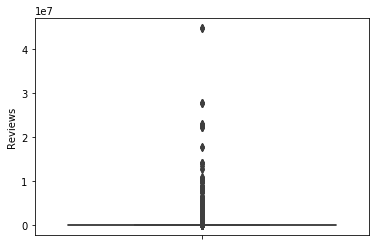

In [16]:
sns.boxplot(y=df['Reviews'])

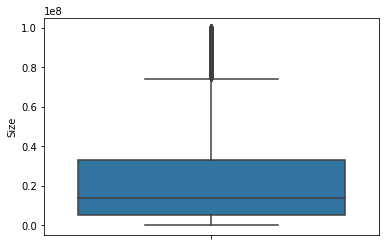

In [17]:
sns.boxplot(y=df['Size'])

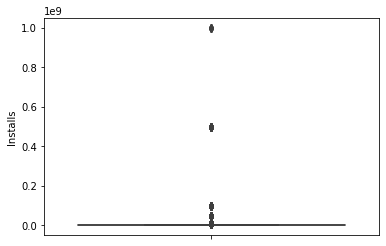

In [18]:
sns.boxplot(y=df['Installs'])

We log transform the reviews and installs features

In [19]:
df['Reviews'] = np.log(df['Reviews'])
df['Installs'] = np.log(df['Installs'])

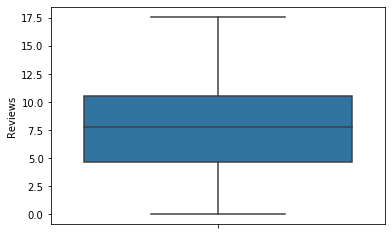

In [20]:
sns.boxplot(y=df['Reviews'])

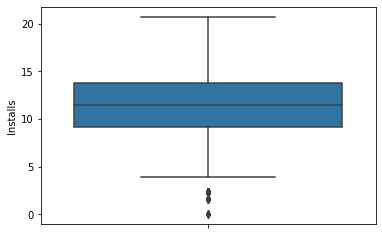

In [21]:
sns.boxplot(y=df['Installs'])

Now, we start modeling our target.

In [22]:
X = df.drop(columns = 'Rating', axis=1)
Y = df['Rating']

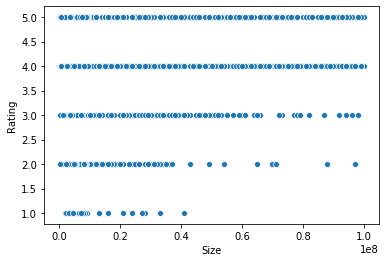

In [23]:
sns.scatterplot(x=df['Size'], y=Y)
plt.show()

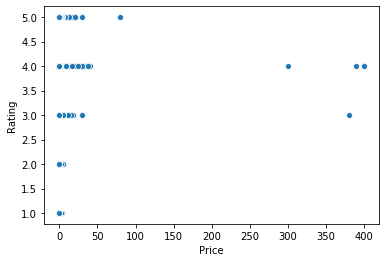

In [24]:
sns.scatterplot(x=df['Price'], y=Y)
plt.show()

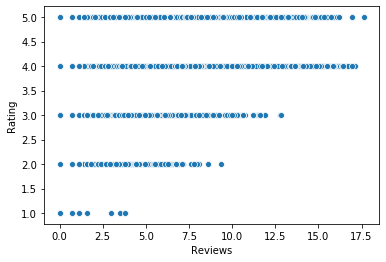

In [25]:
sns.scatterplot(x=df['Reviews'], y=Y)
plt.show()

Correlation seems poorer with low price, low number of reviews, and low app file size. The data appears to be moderately less noisy as each of these features increase in value.

We consider decision trees and random forest models

In [26]:
dtc = tree.DecisionTreeClassifier(max_depth=7)
dtc.fit(X, Y)

score = cross_val_score(dtc, X, Y, cv=10)
print(score)
print("Accuracy: %0.2f (+/- %0.2f)" % (score.mean(), score.std() * 2))

[0.71151358 0.6843467  0.6610608  0.70116429 0.72703752 0.72962484
 0.71632124 0.73056995 0.73151751 0.71168831]
Accuracy: 0.71 (+/- 0.04)


In [27]:
dtc.feature_importances_

array([0.16962453, 0.06912058, 0.48257785, 0.03047058, 0.1272379 ,
       0.        , 0.        , 0.01046379, 0.01106086, 0.        ,
       0.        , 0.00657313, 0.00377476, 0.        , 0.        ,
       0.0025754 , 0.00227489, 0.        , 0.        , 0.02775389,
       0.        , 0.        , 0.00702224, 0.00550445, 0.02682972,
       0.        , 0.00464017, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.00265805, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.00517617, 0.        ,
       0.        , 0.00466103, 0.        ])

For the decision tree, the installs feature is the most important. Reviews and Last Updated are also significant.

In [28]:
rfc = ensemble.RandomForestClassifier()
rfc.fit(X,Y)

score = cross_val_score(rfc, X, Y, cv=10)
print(score)
print("Accuracy: %0.2f (+/- %0.2f)" % (score.mean(), score.std() * 2))

[0.70116429 0.69857697 0.71410091 0.69857697 0.70633894 0.69987063
 0.66321244 0.68523316 0.692607   0.68961039]
Accuracy: 0.69 (+/- 0.03)


In [29]:
rfc.feature_importances_

array([2.36733668e-01, 1.94842097e-01, 1.28394308e-01, 1.75494003e-02,
       2.11850760e-01, 3.42902708e-03, 2.25625050e-03, 5.52779503e-03,
       7.87495095e-03, 2.13032816e-03, 5.44967543e-03, 4.25767190e-03,
       4.26992978e-03, 1.52362080e-03, 2.36340323e-03, 1.36988169e-02,
       8.28861481e-03, 3.86891642e-03, 9.70528242e-03, 8.11582603e-03,
       2.66879344e-03, 1.74496794e-03, 9.50957828e-03, 4.43715948e-03,
       9.88074395e-03, 6.32037880e-03, 2.70833647e-03, 6.91300627e-03,
       6.35730394e-03, 5.56585040e-03, 3.78766506e-03, 5.98040680e-03,
       6.79357586e-03, 1.02711220e-02, 4.79418833e-03, 3.58953573e-03,
       1.54009653e-03, 8.22529612e-03, 1.04812573e-02, 4.33508799e-03,
       4.03042154e-03, 7.92233555e-03, 1.25505555e-05])

Here the reviews, size, installs, and last the application was updated are all significant for the random forest model. Interestingly, the single decision tree performed a little better accuracy-wise. Note that the category of the app, the content rating, and the type (paid or free) seemed to have little impact for the performance of either model.

Below is least squares for comparison.

In [30]:
X1 = sm.add_constant(X.astype(float))

results = sm.OLS(Y, X1).fit()

print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                 Rating   R-squared:                       0.122
Model:                            OLS   Adj. R-squared:                  0.117
Method:                 Least Squares   F-statistic:                     24.75
Date:                Tue, 14 Jan 2020   Prob (F-statistic):          1.96e-181
Time:                        15:40:40   Log-Likelihood:                -6514.5
No. Observations:                7723   AIC:                         1.312e+04
Df Residuals:                    7679   BIC:                         1.342e+04
Df Model:                          43                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const           

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2)

lrm = LinearRegression()
lrm.fit(X_train, y_train)

y_preds_train = lrm.predict(X_train)
y_preds_test = lrm.predict(X_test)

print("R-squared of the model in the training set is: {}".format(lrm.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model in the test set is: {}".format(lrm.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))

R-squared of the model in the training set is: 0.1252600963154885
-----Test set statistics-----
R-squared of the model in the test set is: 0.10289486957085303
Mean absolute error of the prediction is: 0.3953890432458653
Mean squared error of the prediction is: 0.3326830863047783
Root mean squared error of the prediction is: 0.5767868638455441
Mean absolute percentage error of the prediction is: 11.169134258282158


The correlation is fairly weak with R-squared value around 0.12; however, the mean percentage error on for prediction is only 11%

We see how k nearest neighbors and a support vector machine perform.

In [32]:
knc = KNeighborsClassifier(n_neighbors=5)
knc.fit(X, Y)

score = cross_val_score(knc, X, Y, cv=10)
print(score)
print("Accuracy: %0.2f (+/- %0.2f)" % (score.mean(), score.std() * 2))

[0.6545925  0.64683053 0.6377749  0.66235446 0.6313066  0.64812419
 0.63341969 0.64119171 0.63942931 0.65324675]
Accuracy: 0.64 (+/- 0.02)


In [33]:
svc = SVC()
svc.fit(X,Y)

score = cross_val_score(svc, X, Y, cv=10)
print(score)
print("Accuracy: %0.2f (+/- %0.2f)" % (score.mean(), score.std() * 2))

[0.7076326  0.72056921 0.70504528 0.71021992 0.69340233 0.68175938
 0.69170984 0.70207254 0.70298314 0.6987013 ]
Accuracy: 0.70 (+/- 0.02)


The KNN model has marginally better variance in the cross validation scores than the decision tree and random forest models; however, the accuracy is worse. The SVM classifier performs as well as the decision tree and random forest models, with slightly lower (better) variance in the CV scores.

To simplify the feature set, we repeat the above removing the price, category, content rating, and type variables since they had weak influence on the models. This narrows the feature set to four, not including the target.

We also make a new feauture, which it the product of the installs and reviews, removing each of these afterwards; note that these two variables are highly correlated. These now leaves three features

In [34]:
df2 = df[['Rating', 'Reviews', 'Size', 'Installs', 'Last Updated']]
df2['Reviews*Installs'] = df2['Reviews']*df2['Installs']
df2 = df2.drop(columns = ['Reviews', 'Installs'], axis=1)
df2

,Rating,Size,Last Updated,Reviews*Installs
0,4,19000000.000,2788,46.686
1,4,14000000.000,2796,90.206
2,5,8700000.000,2994,175.528
3,4,25000000.000,2940,217.719
4,4,2800000.000,2952,79.142
...,...,...,...,...
10833,5,619000.000,1402,26.140
10834,4,2600000.000,2585,12.093
10836,4,53000000.000,2622,30.982
10837,5,3600000.000,2968,6.384


In [35]:
X = df2.drop(columns = 'Rating', axis=1)
Y = df2['Rating']

In [36]:
dtc = tree.DecisionTreeClassifier(max_depth=7)
dtc.fit(X, Y)

score = cross_val_score(dtc, X, Y, cv=10)
print(score)
print("Accuracy: %0.2f (+/- %0.2f)" % (score.mean(), score.std() * 2))

[0.70116429 0.70116429 0.70504528 0.69987063 0.69469599 0.71280724
 0.71373057 0.70725389 0.71206226 0.6961039 ]
Accuracy: 0.70 (+/- 0.01)


In [37]:
dtc.feature_importances_

array([0.15313659, 0.20138675, 0.64547665])

In [38]:
rfc = ensemble.RandomForestClassifier()
rfc.fit(X,Y)

score = cross_val_score(rfc, X, Y, cv=10)
print(score)
print("Accuracy: %0.2f (+/- %0.2f)" % (score.mean(), score.std() * 2))

[0.68564036 0.7309185  0.70504528 0.69987063 0.70375162 0.68175938
 0.68782383 0.6761658  0.67444877 0.66883117]
Accuracy: 0.69 (+/- 0.04)


In [39]:
rfc.feature_importances_

array([0.27375627, 0.30769184, 0.41855188])

In [40]:
knc = KNeighborsClassifier(n_neighbors=5)
knc.fit(X, Y)

score = cross_val_score(knc, X, Y, cv=10)
print(score)
print("Accuracy: %0.2f (+/- %0.2f)" % (score.mean(), score.std() * 2))

[0.6610608  0.67141009 0.6545925  0.64941785 0.63518758 0.64683053
 0.62694301 0.63471503 0.64332036 0.65714286]
Accuracy: 0.65 (+/- 0.03)


In [41]:
svc = SVC()
svc.fit(X,Y)

score = cross_val_score(svc, X, Y, cv=10)
print(score)
print("Accuracy: %0.2f (+/- %0.2f)" % (score.mean(), score.std() * 2))

[0.71798189 0.75808538 0.72703752 0.72186287 0.71280724 0.70116429
 0.70725389 0.70854922 0.69649805 0.71558442]
Accuracy: 0.72 (+/- 0.03)


The classifier models have roughly the same results, with only these three features!

Lastly, we apply PCA (to the larger first feature set), and then afterwards we narrow down the feature set again, keeping the highest few principal components to see if it improves the models.

In [42]:
df3 = df.reset_index(drop=True)
df3

,Rating,Reviews,Size,Installs,Price,Last Updated,Category_AUTO_AND_VEHICLES,Category_BEAUTY,Category_BOOKS_AND_REFERENCE,Category_BUSINESS,Category_COMICS,Category_COMMUNICATION,Category_DATING,Category_EDUCATION,Category_ENTERTAINMENT,Category_EVENTS,Category_FAMILY,Category_FINANCE,Category_FOOD_AND_DRINK,Category_GAME,Category_HEALTH_AND_FITNESS,Category_HOUSE_AND_HOME,Category_LIBRARIES_AND_DEMO,Category_LIFESTYLE,Category_MAPS_AND_NAVIGATION,Category_MEDICAL,Category_NEWS_AND_MAGAZINES,Category_PARENTING,Category_PERSONALIZATION,Category_PHOTOGRAPHY,Category_PRODUCTIVITY,Category_SHOPPING,Category_SOCIAL,Category_SPORTS,Category_TOOLS,Category_TRAVEL_AND_LOCAL,Category_VIDEO_PLAYERS,Category_WEATHER,Type_Paid,Content Rating_Everyone,Content Rating_Everyone 10+,Content Rating_Mature 17+,Content Rating_Teen,Content Rating_Unrated
0,4,5.069,19000000.000,9.210,0.000,2788,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
1,4,6.874,14000000.000,13.122,0.000,2796,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2,5,11.380,8700000.000,15.425,0.000,2994,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
3,4,12.281,25000000.000,17.728,0.000,2940,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
4,4,6.874,2800000.000,11.513,0.000,2952,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7718,5,3.784,619000.000,6.908,0.000,1402,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
7719,4,1.946,2600000.000,6.215,0.000,2585,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
7720,4,3.638,53000000.000,8.517,0.000,2622,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
7721,5,1.386,3600000.000,4.605,0.000,2968,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0


In [43]:
X = df3.drop(columns = 'Rating', axis=1)
Y = df3['Rating']

x = StandardScaler().fit_transform(X)

pca = PCA(n_components=2)
principalcomponents = pca.fit_transform(x)
principaldf = pd.DataFrame(data = principalcomponents
             , columns = ['principal component 1', 'principal component 2'])

print(
    'The percentage of total variance in the dataset explained by the first two components from Sklearn PCA.\n',
    pca.explained_variance_ratio_
)

The percentage of total variance in the dataset explained by the first two components from Sklearn PCA.
 [0.06956618 0.04583555]


In [44]:
df3 = pd.concat([df3, principaldf], axis = 1)
df3

,Rating,Reviews,Size,Installs,Price,Last Updated,Category_AUTO_AND_VEHICLES,Category_BEAUTY,Category_BOOKS_AND_REFERENCE,Category_BUSINESS,Category_COMICS,Category_COMMUNICATION,Category_DATING,Category_EDUCATION,Category_ENTERTAINMENT,Category_EVENTS,Category_FAMILY,Category_FINANCE,Category_FOOD_AND_DRINK,Category_GAME,Category_HEALTH_AND_FITNESS,Category_HOUSE_AND_HOME,Category_LIBRARIES_AND_DEMO,Category_LIFESTYLE,Category_MAPS_AND_NAVIGATION,Category_MEDICAL,Category_NEWS_AND_MAGAZINES,Category_PARENTING,Category_PERSONALIZATION,Category_PHOTOGRAPHY,Category_PRODUCTIVITY,Category_SHOPPING,Category_SOCIAL,Category_SPORTS,Category_TOOLS,Category_TRAVEL_AND_LOCAL,Category_VIDEO_PLAYERS,Category_WEATHER,Type_Paid,Content Rating_Everyone,Content Rating_Everyone 10+,Content Rating_Mature 17+,Content Rating_Teen,Content Rating_Unrated,principal component 1,principal component 2
0,4,5.069,19000000.000,9.210,0.000,2788,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,-0.948,-0.030
1,4,6.874,14000000.000,13.122,0.000,2796,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,-0.343,-0.523
2,5,11.380,8700000.000,15.425,0.000,2994,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0.478,-1.143
3,4,12.281,25000000.000,17.728,0.000,2940,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,2.891,0.355
4,4,6.874,2800000.000,11.513,0.000,2952,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,-0.623,-0.370
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7718,5,3.784,619000.000,6.908,0.000,1402,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,-2.558,0.590
7719,4,1.946,2600000.000,6.215,0.000,2585,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,-1.977,0.734
7720,4,3.638,53000000.000,8.517,0.000,2622,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,-0.759,0.171
7721,5,1.386,3600000.000,4.605,0.000,2968,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,-2.046,0.828


In [45]:
df3 = df3[['Rating', 'Reviews', 'Size', 'Installs', 'Last Updated', 'principal component 1', 'principal component 2']]
df3['Reviews*Installs'] = df3['Reviews']*df3['Installs']
df3 = df3.drop(columns = ['Reviews', 'Installs'], axis=1)
df3

,Rating,Size,Last Updated,principal component 1,principal component 2,Reviews*Installs
0,4,19000000.000,2788,-0.948,-0.030,46.686
1,4,14000000.000,2796,-0.343,-0.523,90.206
2,5,8700000.000,2994,0.478,-1.143,175.528
3,4,25000000.000,2940,2.891,0.355,217.719
4,4,2800000.000,2952,-0.623,-0.370,79.142
...,...,...,...,...,...,...
7718,5,619000.000,1402,-2.558,0.590,26.140
7719,4,2600000.000,2585,-1.977,0.734,12.093
7720,4,53000000.000,2622,-0.759,0.171,30.982
7721,5,3600000.000,2968,-2.046,0.828,6.384


In [46]:
df3.corr()

,Rating,Size,Last Updated,principal component 1,principal component 2,Reviews*Installs
Rating,1.000,0.036,0.107,0.040,-0.028,0.063
Size,0.036,1.000,0.234,0.587,-0.131,0.386
Last Updated,0.107,0.234,1.000,0.324,-0.149,0.239
principal component 1,0.040,0.587,0.324,1.000,0.000,0.772
principal component 2,-0.028,-0.131,-0.149,0.000,1.000,-0.450
Reviews*Installs,0.063,0.386,0.239,0.772,-0.450,1.000


In [47]:
X = df3.drop(columns = 'Rating', axis=1)
Y = df3['Rating']

First we revisit least squares

In [48]:
X1 = sm.add_constant(X.copy())

results = sm.OLS(Y, X1).fit()

print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                 Rating   R-squared:                       0.017
Model:                            OLS   Adj. R-squared:                  0.016
Method:                 Least Squares   F-statistic:                     26.38
Date:                Tue, 14 Jan 2020   Prob (F-statistic):           1.60e-26
Time:                        15:50:12   Log-Likelihood:                -6950.3
No. Observations:                7723   AIC:                         1.391e+04
Df Residuals:                    7717   BIC:                         1.395e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     3.46

In [49]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2)

lrm = LinearRegression()
lrm.fit(X_train, y_train)

y_preds_train = lrm.predict(X_train)
y_preds_test = lrm.predict(X_test)

print("R-squared of the model in the training set is: {}".format(lrm.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model in the test set is: {}".format(lrm.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))

R-squared of the model in the training set is: 0.018493769365239165
-----Test set statistics-----
R-squared of the model in the test set is: 0.008754686174083148
Mean absolute error of the prediction is: 0.3932220721501128
Mean squared error of the prediction is: 0.3670326601549176
Root mean squared error of the prediction is: 0.6058322046201552
Mean absolute percentage error of the prediction is: 10.920415554643084


In [112]:
# Here is ElasticNet on the same sets

elasticnet_cv = ElasticNetCV(alphas=alphas, cv=10)

elasticnet_cv.fit(X_train, y_train)

y_preds_train = elasticnet_cv.predict(X_train)
y_preds_test = elasticnet_cv.predict(X_test)

print("Best alpha value is: {}".format(elasticnet_cv.alpha_))
print("R-squared of the model in training set is: {}".format(elasticnet_cv.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model in test set is: {}".format(elasticnet_cv.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))

Best alpha value is: 1e-07
R-squared of the model in training set is: 0.01731084773253022
-----Test set statistics-----
R-squared of the model in test set is: 0.01356895458520413
Mean absolute error of the prediction is: 0.3909148179386549
Mean squared error of the prediction is: 0.359858012770489
Root mean squared error of the prediction is: 0.5998816656395568
Mean absolute percentage error of the prediction is: 10.749656660628853


Even with a horrendous R-squared value, the mean absolute percentage error of the predictions is only around 11 percent! We now return to the classifier models used above.

In [50]:
dtc = tree.DecisionTreeClassifier(max_depth=7)
dtc.fit(X, Y)

score = cross_val_score(dtc, X, Y, cv=10)
print(score)
print("Accuracy: %0.2f (+/- %0.2f)" % (score.mean(), score.std() * 2))

[0.71021992 0.69857697 0.69728331 0.70633894 0.70504528 0.69987063
 0.68911917 0.71502591 0.72503243 0.7025974 ]
Accuracy: 0.70 (+/- 0.02)


In [51]:
rfc = ensemble.RandomForestClassifier()
rfc.fit(X,Y)

score = cross_val_score(rfc, X, Y, cv=10)
print(score)
print("Accuracy: %0.2f (+/- %0.2f)" % (score.mean(), score.std() * 2))

[0.69987063 0.71798189 0.69081501 0.69728331 0.7076326  0.6843467
 0.66321244 0.6865285  0.69649805 0.67532468]
Accuracy: 0.69 (+/- 0.03)


Now with a more carefully selected feature set along with PCA, we apply a grid search to improve the random forest model.

In [52]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


In [53]:
from sklearn.model_selection import GridSearchCV

# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 1000]
}
# Create a based model
rfc = ensemble.RandomForestClassifier()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rfc, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

In [54]:
# Fit the grid search to the data
grid_search.fit(X, Y)
grid_search.best_params_

Fitting 3 folds for each of 288 candidates, totalling 864 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   32.1s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  6.3min
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed: 11.6min
[Parallel(n_jobs=-1)]: Done 864 out of 864 | elapsed: 15.7min finished


{'bootstrap': True,
 'max_depth': 110,
 'max_features': 2,
 'min_samples_leaf': 3,
 'min_samples_split': 8,
 'n_estimators': 300}

In [55]:
best_grid = grid_search.best_estimator_
#grid_accuracy = evaluate(best_grid, X, Y)

In [56]:
best_grid.fit(X,Y)

score = cross_val_score(best_grid, X, Y, cv=10)
print(score)
print("Accuracy: %0.2f (+/- %0.2f)" % (score.mean(), score.std() * 2))

[0.70375162 0.71668823 0.72186287 0.7076326  0.72445019 0.71798189
 0.71632124 0.71891192 0.73022049 0.71428571]
Accuracy: 0.72 (+/- 0.01)


Adding the PCA components marginally improved the models.

In [57]:
knc = KNeighborsClassifier(n_neighbors=5)
knc.fit(X, Y)

score = cross_val_score(knc, X, Y, cv=10)
print(score)
print("Accuracy: %0.2f (+/- %0.2f)" % (score.mean(), score.std() * 2))

[0.66235446 0.67011643 0.65329884 0.64941785 0.63389392 0.64683053
 0.62694301 0.63341969 0.64332036 0.65714286]
Accuracy: 0.65 (+/- 0.03)


In [58]:
svc = SVC()
svc.fit(X,Y)

score = cross_val_score(svc, X, Y, cv=10)
print(score)
print("Accuracy: %0.2f (+/- %0.2f)" % (score.mean(), score.std() * 2))

[0.71927555 0.75808538 0.72833118 0.72056921 0.71280724 0.70116429
 0.70854922 0.70854922 0.69779507 0.71558442]
Accuracy: 0.72 (+/- 0.03)


In conclusion all of the classifier models considered above seem to perform with similar accuracy/variance in cross validation. KNN is slightly weaker than the rest.